In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

58892288/58889256 [==============================] - 191s 3us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'cat_dog_data_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [9]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)
history = model.fit(
    train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 714us/sample - loss: 0.5901 - acc: 0.6830 - val_loss: 0.4390 - val_acc: 0.8490
Epoch 2/30
2000/2000 [==============================] - 0s 243us/sample - loss: 0.4308 - acc: 0.7985 - val_loss: 0.3684 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 0s 237us/sample - loss: 0.3611 - acc: 0.8455 - val_loss: 0.3289 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 1s 258us/sample - loss: 0.3191 - acc: 0.8665 - val_loss: 0.3030 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 0s 246us/sample - loss: 0.2904 - acc: 0.8800 - val_loss: 0.2947 - val_acc: 0.8840
Epoch 6/30
2000/2000 [==============================] - 0s 244us/sample - loss: 0.2627 - acc: 0.8955 - val_loss: 0.2742 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 0s 247us/sample - loss: 0.2538 - acc: 0.9025 - val_loss: 0.2720 - va

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


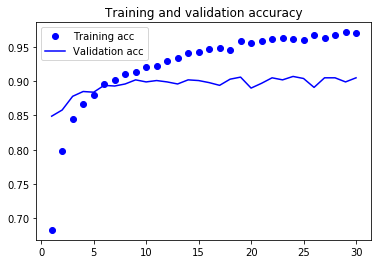

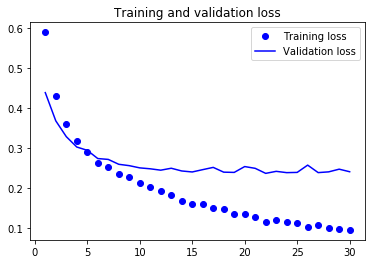

In [13]:
import matplotlib.pyplot as plt

print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()